In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import torch
import torchvision

import numpy as np
from PIL import Image
from core.dataset import ImageDataset

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data")
CHECKPOINT_DIR = os.path.join(DATA_DIR, "checkpoints")

In [394]:
from api.app import load_transform
normal_image_paths = glob.glob("./data/normal/*.jpg")
rupture_image_paths = glob.glob("./data/rupture/*.jpg")

image_idx = 3006
tranform = load_transform()
dataset = ImageDataset(normal_image_paths+rupture_image_paths, size=(256, 256), transform=tranform)
image, label = dataset[image_idx]
print(image.shape)

torch.Size([3, 224, 224])


In [395]:
model = torchvision.models.efficientnet_b3()
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 1)
dd_model = torch.nn.DataParallel(model)
dd_model.load_state_dict(
    torch.load(os.path.join(CHECKPOINT_DIR, "efficient_net_best_weight.pt"))
)
_ = model.eval()

In [396]:
# forward

logit = model(image.unsqueeze(dim=0))
print(torch.sigmoid(logit))

tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [397]:
# GradCAM

def grad_cam(model, image, target_layer):
    def forward_hook(module, input, output):
        grad_cam_data["feature_map"] = output
    def backward_hook(module, grad_input, grad_output):
        grad_cam_data["grad_output"] = grad_output[0]

    grad_cam_data = {}
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    output = model(image)
    model.zero_grad()
    output[0, output.argmax()].backward()

    feature_map = grad_cam_data["feature_map"]
    grad_output = grad_cam_data["grad_output"]
    weights = grad_output.mean(dim=(2, 3), keepdim=True)
    cam = (weights * feature_map).sum(1, keepdim=True).squeeze()
    cam = cam.detach().cpu().numpy()

    return cam
        



./data/rupture/37_202106111721294560037 58.jpg


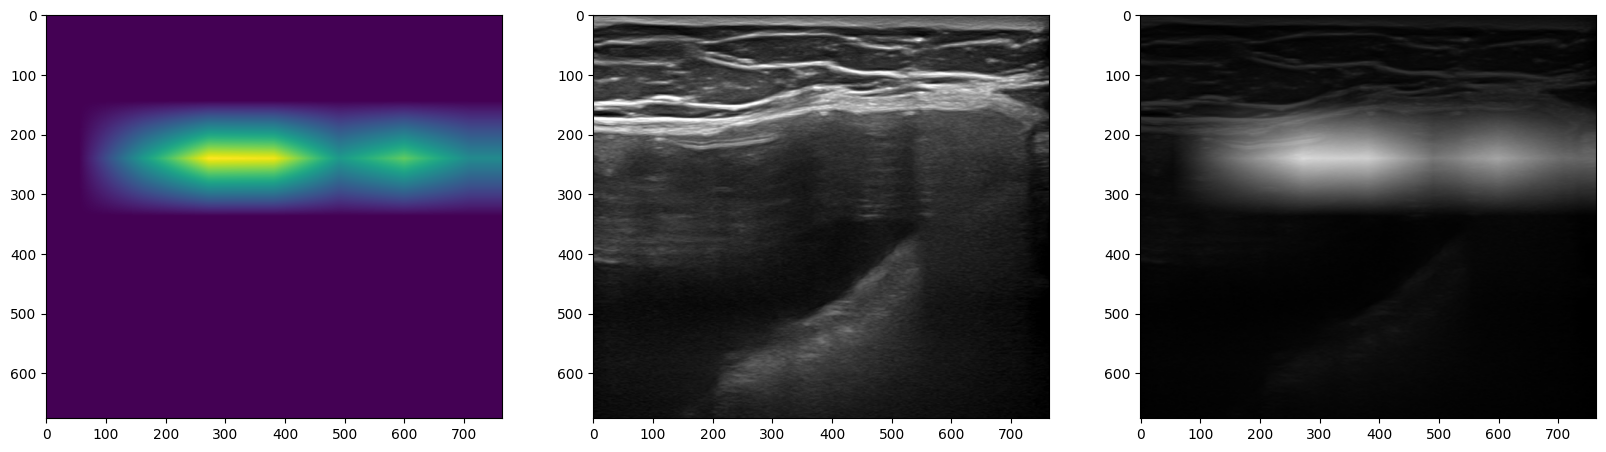

In [398]:
from matplotlib import pyplot as plta
import cv2

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
def postprocess_cam(cam, size):   
    cam = np.clip(cam, a_min=0, a_max=cam.max())
    
    cam = cam / np.max(cam)    # 정규화합니다.
    
    cam[cam<=cam.mean() + cam.std()] = 0
    cam = cv2.resize(cam, size)  # 원본 이미지 크기로 조절합니다.
    return cam *255


from core.transform import crop_usimage
original_image = Image.open((normal_image_paths+rupture_image_paths)[image_idx]).convert("L")
print((normal_image_paths+rupture_image_paths)[image_idx])
crop_image, _ = crop_usimage(np.array(original_image))

cam = grad_cam(model, image=image.unsqueeze(dim=0), target_layer=model.features[-1])
post_processcam = postprocess_cam(cam, crop_image.shape[::-1])
axes[0].imshow(post_processcam)
# heatmap = cv2.applyColorMap(np.uint8(255 * post_processcam), cv2.COLORMAP_JET)
result = post_processcam * 0.5 + crop_image * 0.5

alpha = 0.8
# overlay = crop_image.copy()
heatmap_expanded = np.expand_dims(post_processcam, axis=-1)
original_image_color = cv2.cvtColor(crop_image, cv2.COLOR_GRAY2RGB)
# overlay[..., 0] = np.where(post_processcam > 0.2, 255, overlay[..., 0])  # Red channel
# output_image = cv2.addWeighted(post_processcam, alpha, crop_image, 1 - alpha, 0)
# overlay = original_image_color.copy()
# overlay = (overlay * (1 - heatmap_expanded) + heatmap_expanded * 255).astype(np.uint8)
output_image = cv2.addWeighted(np.repeat(heatmap_expanded, repeats=3, axis=-1).astype(np.uint8), alpha, original_image_color, 1 - alpha, 0)

axes[1].imshow(crop_image, cmap='gray')
axes[2].imshow(output_image)
